In [1]:
import model

In [2]:
    data_path = "H-1B_2017.csv"
    mo = model.Model(data_path)

In [3]:
    X_train, X_test, y_train, y_test = mo.get_data()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (14,15,16,24) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/ubuntu/Capstone/create_features_DF.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['CASE_STATUS'] = (df['CASE_STATUS'] == 'DENIED').astype(int)


In [6]:
X_train.CASE_STATUS.value_counts()

0    373534
1      5237
Name: CASE_STATUS, dtype: int64

In [8]:
Dx = X_train[X_train['CASE_STATUS'] == 1]

In [9]:
Cx = X_train[X_train['CASE_STATUS'] == 0]

In [4]:
from sklearn.model_selection import train_test_split

In [10]:
X_train2, X_test_extra, y_train2, y_test_extra = train_test_split(Cx,Cx.CASE_STATUS, train_size= 0.06, random_state=1)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [12]:
X_train2.CASE_STATUS.value_counts()

0    22412
Name: CASE_STATUS, dtype: int64

In [13]:
training_dataframe = X_train2.append(Dx)

In [14]:
training_dataframe.CASE_STATUS.value_counts()

0    22412
1     5237
Name: CASE_STATUS, dtype: int64

In [15]:
training_dataframe_y = training_dataframe.CASE_STATUS.values

In [4]:
df=X_train

In [5]:
        df['per_employer']=df.groupby('EMPLOYER_NAME')['EMPLOYER_NAME'].transform('count')
        df['per_employer_deny']=df.groupby('EMPLOYER_NAME')['CASE_STATUS'].transform('sum')
        df['EMPLOYER_RATE']=df['per_employer_deny']/df['per_employer']

In [6]:
mask = df.per_employer < 5
df_5=df[mask]

1.0    29201
2.0    17214
3.0    10935
4.0     8276
Name: per_employer, dtype: int64

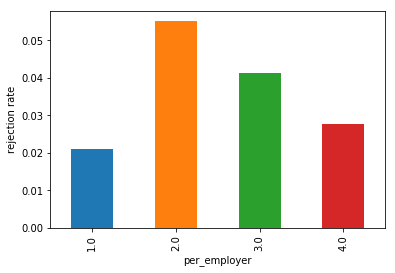

In [7]:
agg = df_5.groupby('per_employer')['CASE_STATUS'].mean()
agg.plot(kind='bar').set_ylabel('rejection rate')
df_5.per_employer.value_counts()

In [8]:
df_5.CASE_STATUS.mean()

0.0342851918446957

In [9]:
        df['per_soc']=df.groupby('SOC_NAME')['SOC_NAME'].transform('count')
        df['per_soc_deny']=df.groupby('SOC_NAME')['CASE_STATUS'].transform('sum')
        df['SOC_RATE']=df['per_soc_deny']/df['per_soc']

In [10]:
mask_soc = df.per_soc < 5
df_5soc=df[mask_soc]

1    195
4    136
3    135
2    120
Name: per_soc, dtype: int64

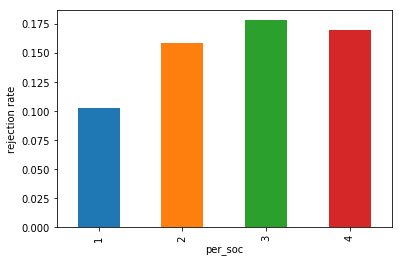

In [11]:
agg = df_5soc.groupby('per_soc')['CASE_STATUS'].mean()
agg.plot(kind='bar').set_ylabel('rejection rate')
df_5soc.per_soc.value_counts()

In [12]:
df_5soc.CASE_STATUS.mean()

0.14675767918088736

In [16]:
X, df_save_em, df_save_so = model.create_features_df(training_dataframe, predict=False)

In [17]:
    X_test=model.create_features_df(X_test)
    group=dict(zip(df_save_em.EMPLOYER_NAME,df_save_em.EMPLOYER_RATE))
    X_test['EMPLOYER_RATE'] = X_test['EMPLOYER_NAME'].map(group, na_action=None)
    X_test.fillna(0.0343, inplace=True)

In [18]:
    group=dict(zip(df_save_so.SOC_NAME,df_save_so.SOC_RATE))
    X_test['SOC_RATE'] = X_test['SOC_NAME'].map(group, na_action=None)
    X_test.fillna(0.1468, inplace=True)

In [19]:
    missing_cols = set(X.columns)-set(X_test.columns)
# Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        X_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
    X_test= X_test[X.columns]
    X_test.drop(['EMPLOYER_NAME','SOC_NAME','CASE_STATUS'], inplace=True, axis=1)
    X.drop(['EMPLOYER_NAME','SOC_NAME', 'CASE_STATUS'], inplace=True, axis=1)

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

In [21]:
gbcc=GradientBoostingClassifier(n_estimators=500, max_depth=8, subsample=0.5,max_features='auto', learning_rate=0.05)

In [23]:
gbcc.fit(X, training_dataframe_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [24]:
import sklearn.metrics as skm
skm.roc_auc_score(y_test,gbcc.predict_proba(X_test)[:, 1])

0.64648307542933958

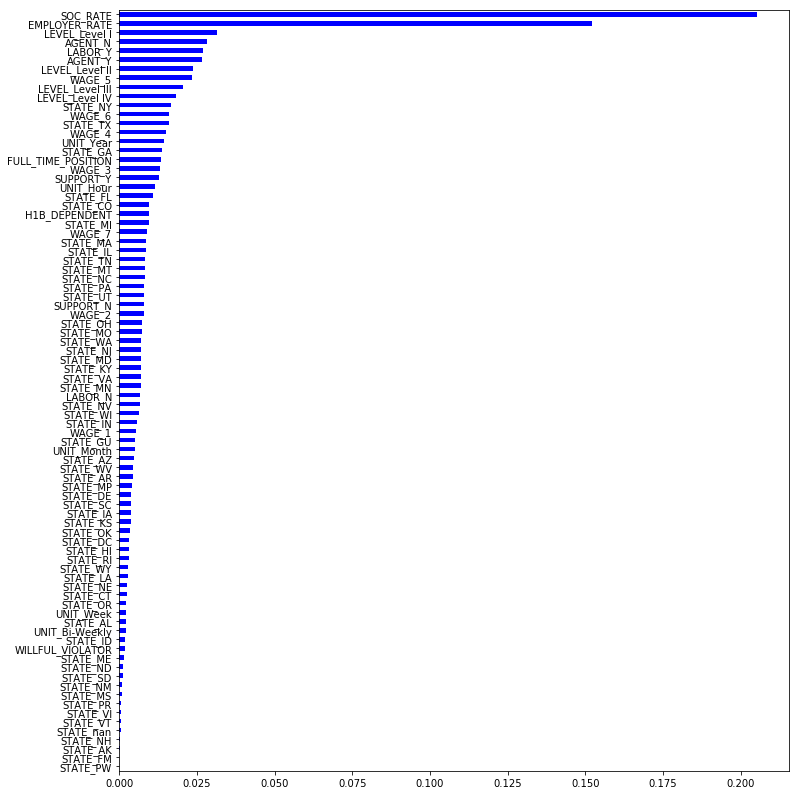

In [25]:
import pandas as pd
feat_scores = pd.Series(gbcc.feature_importances_,
                           index=X.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(12,14),
                      color='b')

In [26]:
X['comb']=X.SOC_RATE*X.EMPLOYER_RATE

In [27]:
X_test['comb']=X_test.SOC_RATE*X_test.EMPLOYER_RATE

In [32]:
gbcc2=GradientBoostingClassifier(n_estimators=500, max_depth=8, subsample=0.5,max_features='auto', learning_rate=0.05)

In [33]:
gbcc2.fit(X, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [34]:
import sklearn.metrics as skm
skm.roc_auc_score(y_test,gbcc2.predict_proba(X_test)[:, 1])

0.7550968971227955